In [1]:
#Install Ultralytics
%%time

! pip install --upgrade ultralytics -qq

CPU times: total: 0 ns
Wall time: 5.4 s


In [2]:
import ultralytics
print(ultralytics.__version__)

8.0.196


In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO

In [4]:
import os
os.environ['WANDB_MODE'] = 'offline'

In [5]:
class CFG:
    DEBUG = False
    FRACTION = 0.05 if DEBUG else 1.0
    SEED = 88

    # classes
    CLASSES = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask',
               'NO-Safety Vest', 'Person', 'Safety Cone',
               'Safety Vest', 'machinery', 'vehicle']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 100
    BATCH_SIZE = 16
    
    BASE_MODEL = 'yolov8x' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'
    
    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0    

    # paths
    CUSTOM_DATASET_DIR = '/Users/julia\OneDrive - Pienaar Bros/1_PB_OD_Documents/IUBH-DataScience/PROJECT FROM MODEL TO PRODUCTION/Kaggle/css-data/'
    OUTPUT_DIR = './'

In [6]:
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)

In [7]:
### read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

### print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- Hardhat
- Mask
- NO-Hardhat
- NO-Mask
- NO-Safety Vest
- Person
- Safety Cone
- Safety Vest
- machinery
- vehicle
nc: 10
test: /Users/julia\OneDrive - Pienaar Bros/1_PB_OD_Documents/IUBH-DataScience/PROJECT
  FROM MODEL TO PRODUCTION/Kaggle/css-data/test
train: /Users/julia\OneDrive - Pienaar Bros/1_PB_OD_Documents/IUBH-DataScience/PROJECT
  FROM MODEL TO PRODUCTION/Kaggle/css-data/train
val: /Users/julia\OneDrive - Pienaar Bros/1_PB_OD_Documents/IUBH-DataScience/PROJECT
  FROM MODEL TO PRODUCTION/Kaggle/css-data/valid



In [8]:
def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\n')
        print('Shape: ', np.array(img).shape, '\n')

    if hide_axis:
        plt.axis('off')

    plt.show()

Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



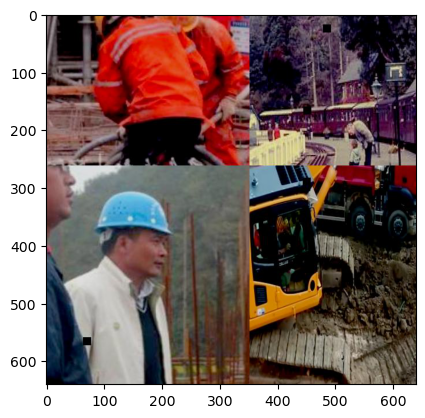

In [9]:
example_image_path = '/Users/julia\OneDrive - Pienaar Bros/1_PB_OD_Documents/IUBH-DataScience/PROJECT FROM MODEL TO PRODUCTION/Kaggle/css-data/train/images/-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

In [10]:
def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):
    
    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))
        
        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]
        
        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

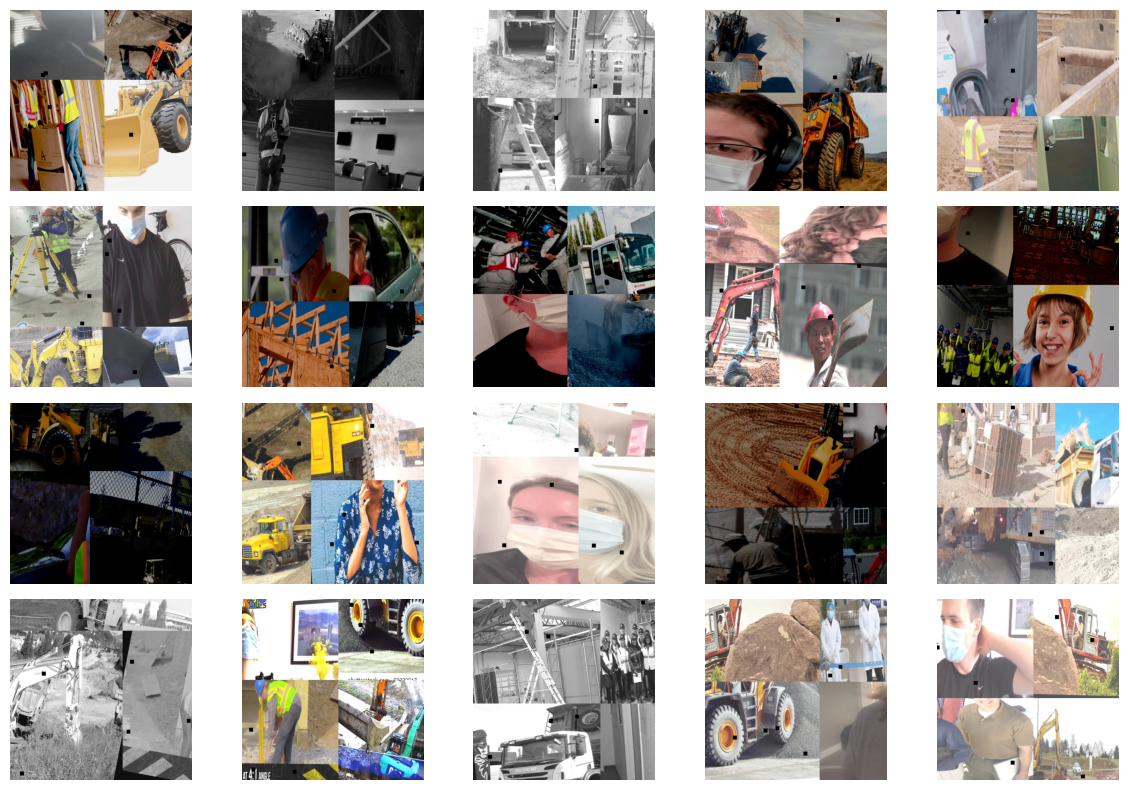

In [11]:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)
# plot_random_images_from_folder(folder_path, num_images=20, seed=54)

In [12]:
def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

In [13]:
img_properties = get_image_properties(example_image_path)
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [14]:
%%time
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
dataset_stats_df

CPU times: total: 250 ms
Wall time: 812 ms


,Mode,Hardhat,Mask,NO-Hardhat,NO-Mask,NO-Safety Vest,Person,Safety Cone,Safety Vest,machinery,vehicle,Data_Volume
0,train,1309,1087,1369,1523,1850,2511,630,1316,2092,742,2590
1,valid,42,18,36,43,55,83,13,28,26,16,113
2,test,30,16,25,30,36,59,8,22,22,15,82


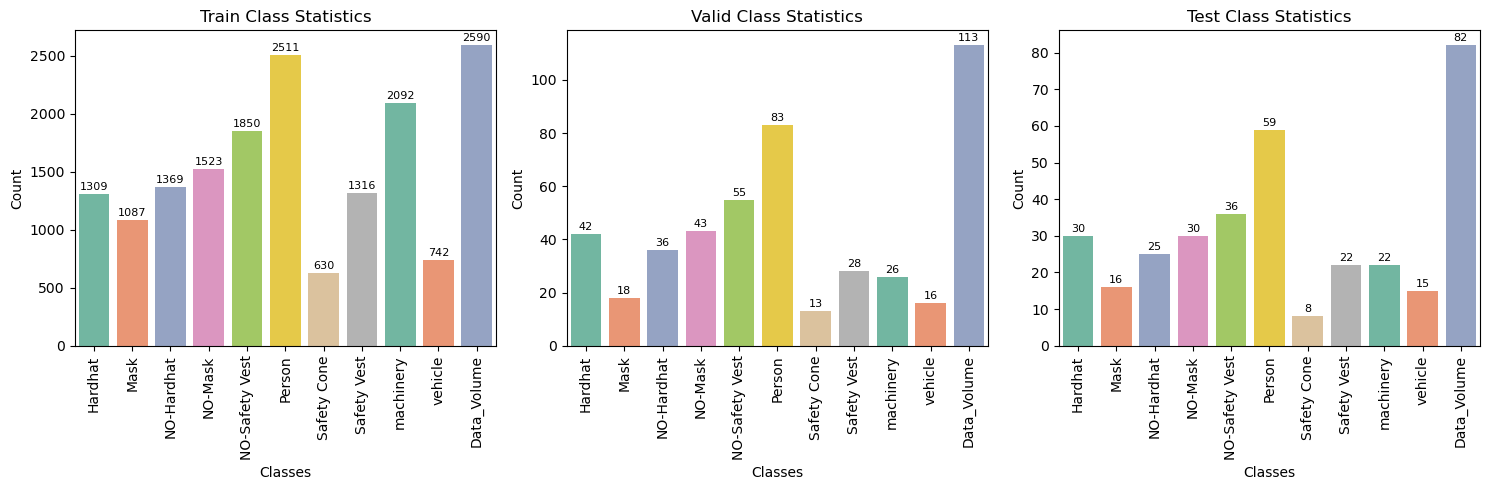

In [15]:
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )
    
    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90) 

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

In [16]:
%%time

for mode in ['train', 'valid', 'test']:
    print(f'\nImage sizes in {mode} set:')

    img_size = 0
    for file in glob.glob(os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'images', '*')):

        image = Image.open(file)

        if image.size != img_size:
            print(f'{image.size}')
            img_size = image.size
            print('\n')


Image sizes in train set:
(640, 640)



Image sizes in valid set:
(640, 640)



Image sizes in test set:
(640, 640)


CPU times: total: 344 ms
Wall time: 1.05 s


In [17]:
CFG.BASE_MODEL_WEIGHTS

'yolov8x.pt'

In [18]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,

    classes = [0],
    conf = 0.30,
    device = [0], # 1GPU
    imgsz = (img_properties['height'], img_properties['width']),

    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)


image 1/1 C:\Users\julia\OneDrive - Pienaar Bros\1_PB_OD_Documents\IUBH-DataScience\PROJECT FROM MODEL TO PRODUCTION\Kaggle\css-data\train\images\-2297-_png_jpg.rf.9fff3740d864fbec9cda50d783ad805e.jpg: 640x640 9 persons, 74.0ms
Speed: 6.0ms preprocess, 74.0ms inference, 23.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
1 label saved to runs\detect\predict\labels


Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> 

Shape:  (640, 640, 3) 



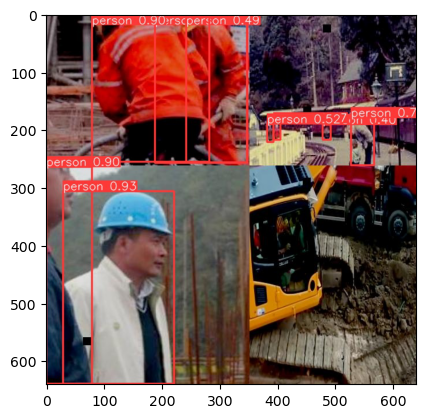

In [19]:
### check predictions with base model
example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'/Users/julia/runs/detect/predict/{example_image_inference_output}')

In [20]:
print('Model: ', CFG.BASE_MODEL_WEIGHTS)
print('Epochs: ', CFG.EPOCHS)
print('Batch: ', CFG.BATCH_SIZE)

Model:  yolov8x.pt
Epochs:  100
Batch:  16


In [21]:
### Load pre-trained YOLO model
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [22]:
import torch

In [23]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
torch.cuda.empty_cache()

In [24]:
%%time

### train
model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    imgsz = (img_properties['height'], img_properties['width']),
    


    epochs = 20,
    batch = 1,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,
    
    val = True,
    amp = True,    
    exist_ok = True,
    resume = False,
    device = 0,
    verbose = False,
    #workers=0,
)


Ultralytics YOLOv8.0.196  Python-3.9.18 torch-2.2.0.dev20230925+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8x.pt, data=./data.yaml, epochs=20, patience=20, batch=1, imgsz=(640, 640), save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8x_ppe_css_100_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxe

CPU times: total: 11h 22s
Wall time: 2h 57min 58s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000029C3194ED90>
fitness: 0.4168187509616055
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.50213,     0.52122,     0.37077,     0.35553,     0.27501,     0.39493,     0.39958,     0.44177,      0.4224,     0.16208])
names: {0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}
plot: True
results_dict: {'metrics/precision(B)': 0.764316445092206, 'metrics/recall(B)': 0.6854014487042426, 'metrics/mAP50(B)': 0.707314426865656, 'metrics/mAP50-95(B)': 0.38454145363893316, 'fitness': 0.4168187509616055}
save_dir: WindowsPath('runs/detect/yolov8x_ppe_css_100_epochs')
speed: {'preprocess': 0.56587

In [25]:
img_properties

{'width': 640, 'height': 640, 'channels': 3, 'dtype': dtype('uint8')}

In [26]:
# Export the model
model.export(
    format = 'openvino', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

Ultralytics YOLOv8.0.196  Python-3.9.18 torch-2.2.0.dev20230925+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Model summary (fused): 268 layers, 68133198 parameters, 0 gradients, 257.4 GFLOPs

PyTorch: starting from 'runs\detect\yolov8x_ppe_css_100_epochs\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (130.4 MB)

ONNX: starting export with onnx 1.14.1 opset 17...
ONNX: export success  3.0s, saved as 'runs\detect\yolov8x_ppe_css_100_epochs\weights\best.onnx' (260.1 MB)

OpenVINO: starting export with openvino 2023.1.0-12185-9e6b00e51cd-releases/2023/1...
OpenVINO: export success  11.4s, saved as 'runs\detect\yolov8x_ppe_css_100_epochs\weights\best_openvino_model\' (260.3 MB)

Export complete (15.4s)
Results saved to C:\Users\julia\runs\detect\yolov8x_ppe_css_100_epochs\weights
Predict:         yolo predict task=detect model=runs\detect\yolov8x_ppe_css_100_epochs\weights\best_openvino_model imgsz=640  
Validate:        yolo val task

'runs\\detect\\yolov8x_ppe_css_100_epochs\\weights\\best_openvino_model'

In [27]:
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov8x_ppe_css_100_epochs\\confusion_matrix.png',
 './runs/detect/yolov8x_ppe_css_100_epochs\\confusion_matrix_normalized.png',
 './runs/detect/yolov8x_ppe_css_100_epochs\\F1_curve.png',
 './runs/detect/yolov8x_ppe_css_100_epochs\\PR_curve.png',
 './runs/detect/yolov8x_ppe_css_100_epochs\\P_curve.png',
 './runs/detect/yolov8x_ppe_css_100_epochs\\results.png',
 './runs/detect/yolov8x_ppe_css_100_epochs\\R_curve.png',
 './runs/detect/yolov8x_ppe_css_100_epochs\\labels.jpg',
 './runs/detect/yolov8x_ppe_css_100_epochs\\labels_correlogram.jpg']

./runs/detect/yolov8x_ppe_css_100_epochs\F1_curve.png


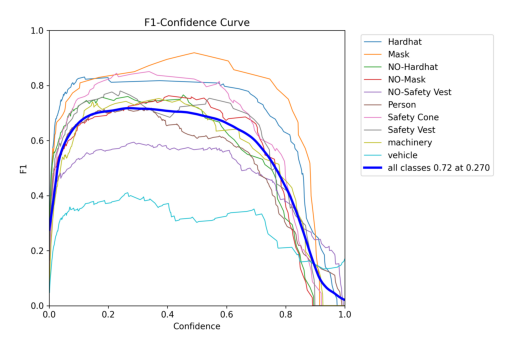



./runs/detect/yolov8x_ppe_css_100_epochs\PR_curve.png


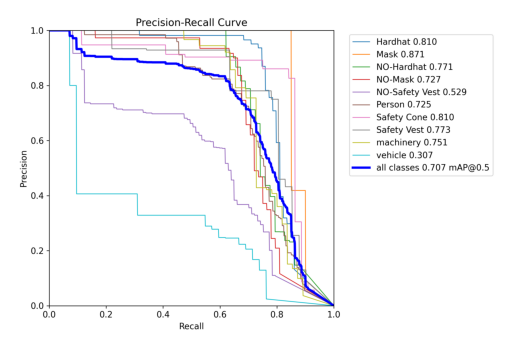



./runs/detect/yolov8x_ppe_css_100_epochs\P_curve.png


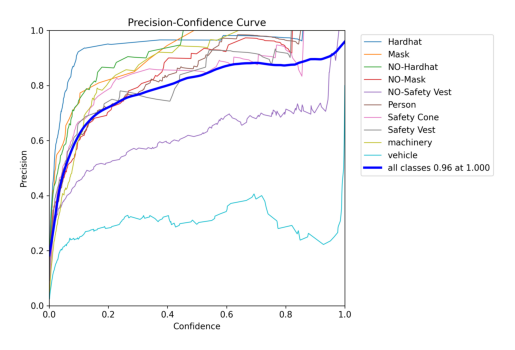



./runs/detect/yolov8x_ppe_css_100_epochs\R_curve.png


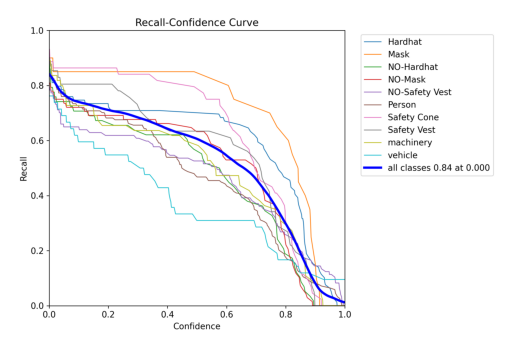



./runs/detect/yolov8x_ppe_css_100_epochs\confusion_matrix.png


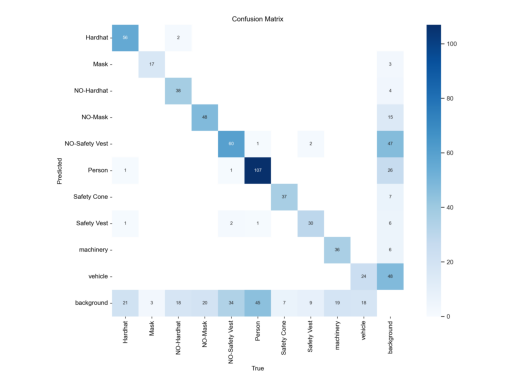



./runs/detect/yolov8x_ppe_css_100_epochs\confusion_matrix_normalized.png


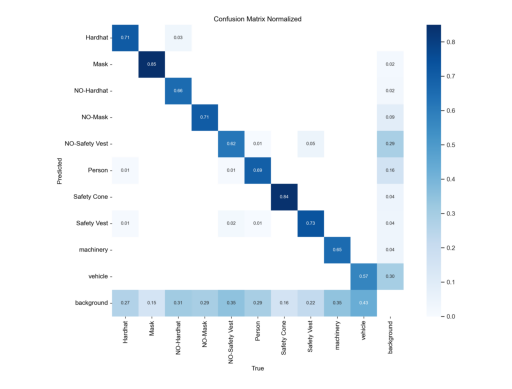



./runs/detect/yolov8x_ppe_css_100_epochs\labels.jpg


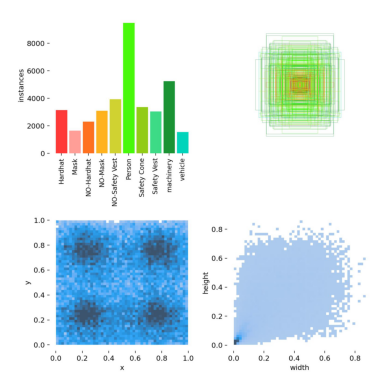



./runs/detect/yolov8x_ppe_css_100_epochs\labels_correlogram.jpg


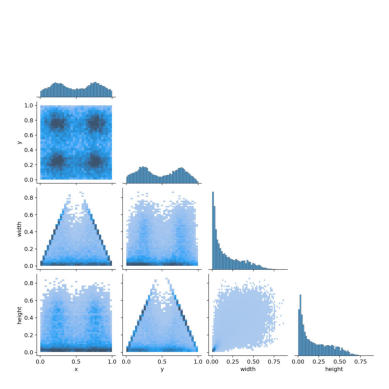



./runs/detect/yolov8x_ppe_css_100_epochs\results.png


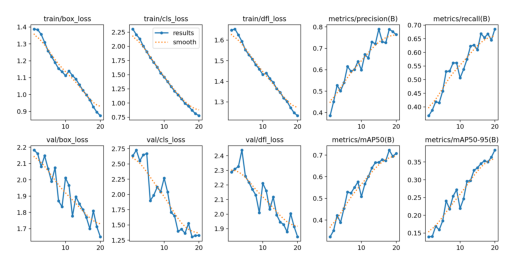

In [28]:
for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [29]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,1.38790,2.30470,1.6479,0.38568,0.36782,0.32279,0.13955,2.1823,2.6333,2.2885,0.000238,0.000238,0.000238
1,1,1.38790,2.30470,1.6479,0.38568,0.36782,0.32279,0.13955,2.1823,2.6333,2.2885,0.000238,0.000238,0.000238
2,2,1.38410,2.20530,1.6536,0.45110,0.38797,0.35129,0.14051,2.1601,2.7262,2.3087,0.000452,0.000452,0.000452
3,3,1.35660,2.13290,1.6246,0.52717,0.41919,0.42153,0.16919,2.0801,2.5504,2.3271,0.000643,0.000643,0.000643
4,4,1.30890,2.00390,1.5935,0.50156,0.41513,0.38887,0.15898,2.1474,2.6488,2.4387,0.000608,0.000608,0.000608
5,5,1.25790,1.90560,1.5528,0.53998,0.45796,0.45404,0.18433,2.0683,2.6694,2.2592,0.000608,0.000608,0.000608
6,6,1.22430,1.80030,1.5286,0.61560,0.52994,0.52937,0.24033,1.9899,1.8977,2.2184,0.000573,0.000573,0.000573
7,7,1.18920,1.71760,1.5074,0.59303,0.53141,0.52492,0.21788,2.0740,1.9849,2.1694,0.000537,0.000537,0.000537
8,8,1.15370,1.63380,1.4800,0.60120,0.56139,0.55063,0.25401,1.8704,2.1195,2.1307,0.000502,0.000502,0.000502
9,9,1.13550,1.52890,1.4594,0.63908,0.56153,0.57597,0.27187,1.8347,2.0442,2.0093,0.000467,0.000467,0.000467


In [30]:
print('*'*50)
print('\nBest Training loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('*'*50)
print('\nBest Validation loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')
print('*'*50)

**************************************************

Best Training loss:  0.87488 , on epoch:  21 

**************************************************

Best Validation loss:  1.6507 , on epoch:  21 

**************************************************


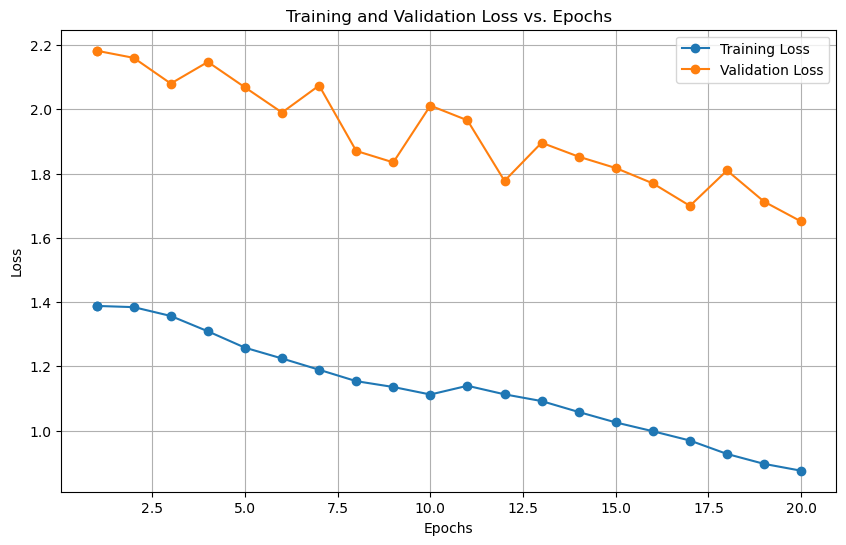

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['train/box_loss'], label='Training Loss', marker='o', linestyle='-')
plt.plot(df['epoch'], df['val/box_loss'], label='Validation Loss', marker='o', linestyle='-')

plt.title('Training and Validation Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

In [1]:
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

NameError: name 'glob' is not defined

In [33]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov8x_ppe_css_100_epochs\val_batch2_pred.jpg


./runs/detect/yolov8x_ppe_css_100_epochs\val_batch1_labels.jpg


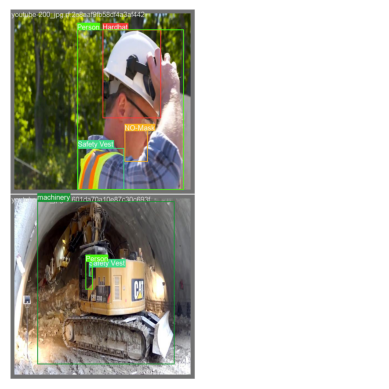

In [34]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)